# Best CNN

Tamaño en memoria: 0.01 GB
Proceso Iniciado: CNN de 5 kernels, stride de 2, padding de 1 y tamaño de FC 64
25 = 25.0
11 = 11.0
Tamaño después de convolución y pooling: 3872
Usando el dispositivo: mps
Epoch 1, Loss: 1.5453, Val Loss: 1.4355, Val Acc: 67.30%
Epoch 2, Loss: 1.3929, Val Loss: 1.2839, Val Acc: 73.37%
Epoch 3, Loss: 1.2578, Val Loss: 1.1484, Val Acc: 74.94%
Epoch 4, Loss: 1.1518, Val Loss: 1.0407, Val Acc: 76.18%
Epoch 5, Loss: 1.0638, Val Loss: 0.9534, Val Acc: 76.85%
Epoch 6, Loss: 0.9919, Val Loss: 0.8825, Val Acc: 77.64%
Epoch 7, Loss: 0.9399, Val Loss: 0.8262, Val Acc: 78.00%
Epoch 8, Loss: 0.8922, Val Loss: 0.7798, Val Acc: 78.54%
Epoch 9, Loss: 0.8521, Val Loss: 0.7386, Val Acc: 78.89%
Epoch 10, Loss: 0.8188, Val Loss: 0.7061, Val Acc: 79.79%
Epoch 11, Loss: 0.7920, Val Loss: 0.6786, Val Acc: 80.15%
Epoch 12, Loss: 0.7618, Val Loss: 0.6521, Val Acc: 80.76%
Epoch 13, Loss: 0.7428, Val Loss: 0.6301, Val Acc: 81.25%
Epoch 14, Loss: 0.7177, Val Loss: 0.6095, Val Acc: 81.5

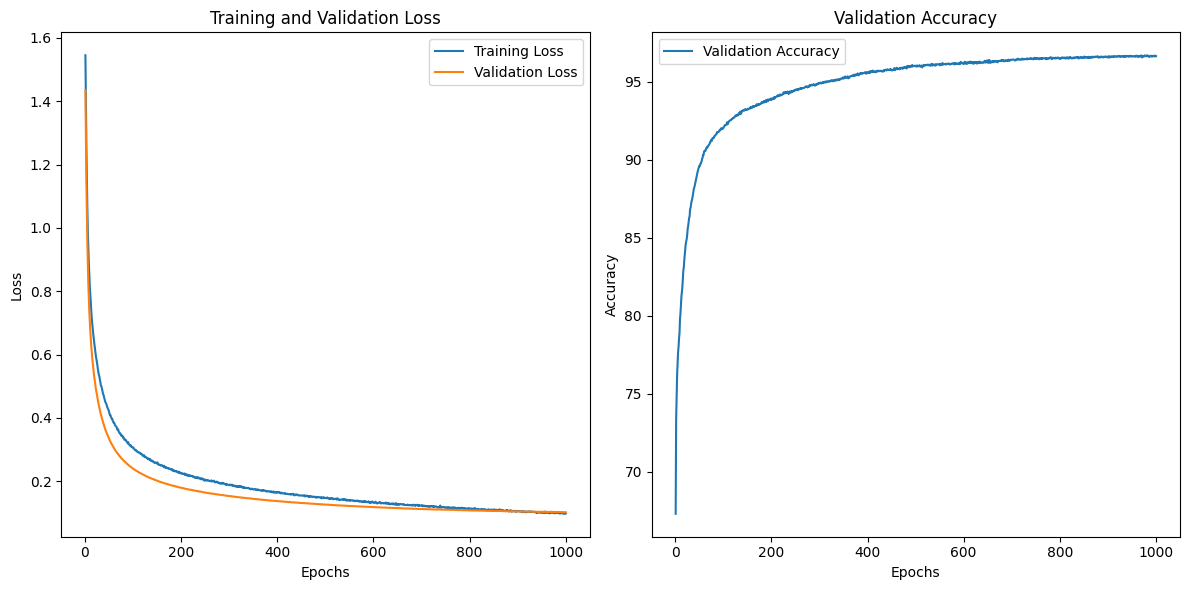

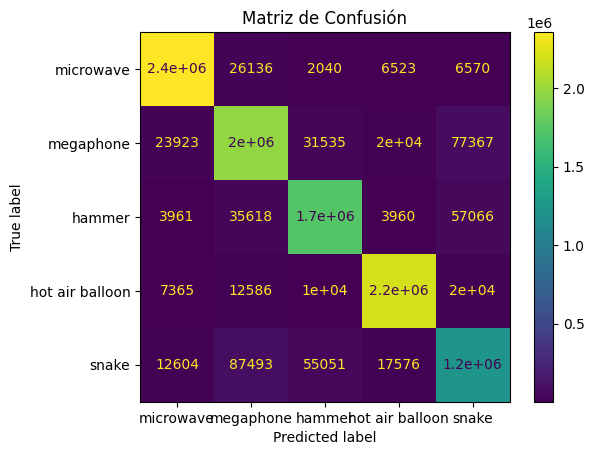

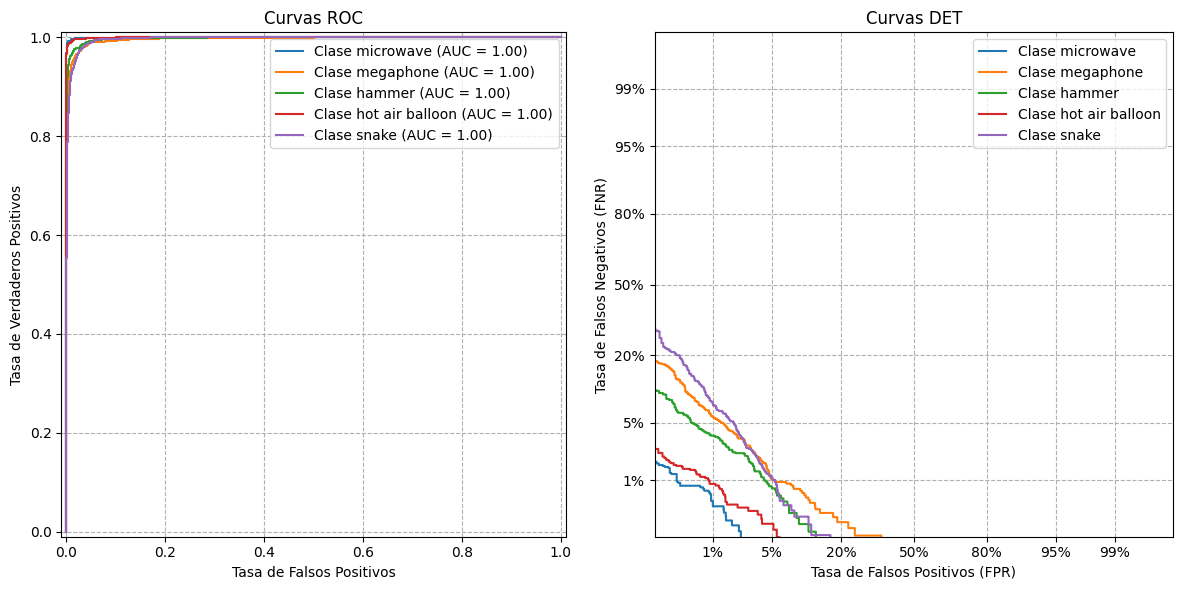

PROCESO FINALIZADO, TODOS LOS ARCHIVOS DESCARGADOS


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from scipy.stats import norm
import random
import torch.optim as optim
from torch import tensor
from sklearn.metrics import classification_report
import sys
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
import torch.nn.functional as F
import math

sys.stdout.flush()

data_numpy = np.load('data_all.npy', allow_pickle=True)
print(f"Tamaño en memoria: {data_numpy.nbytes / 1e9:.2f} GB")


data_local = True 

if data_local == True:
    # Barajar las filas de la matriz
    #np.random.seed(42)  # Semilla para reproducibilidad
    indices = np.random.permutation(len(data_numpy))  # Crear índices aleatorios
    data_numpy_shuffled = data_numpy[indices]  # Barajar la matriz completa
    
    # Tomar un subconjunto (por ejemplo, 10,000 muestras)
    subset_size = 50000
    data_numpy = data_numpy_shuffled[:subset_size]
    batch = 500
else:
    batch = 5000

# Separar imágenes y etiquetas después del muestreo
data_sample_images = np.array([item[0] for item in data_numpy])
data_sample_labels = np.array([item[1] for item in data_numpy])

# Dividir los datos con muestreo estratificado
X_train, X_test, y_train, y_test = train_test_split(
    data_sample_images, data_sample_labels, test_size=0.2, random_state=42)


# Crear el DataLoader con la clase modificada
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset personalizado para PyTorch
class QuickDrawDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images*255  # Nueva escala ajustada
        self.labels = labels
        self.transform = transform

        # Crear el mapeo de clases a índices solo una vez
        self.classes = list(set(labels))  # Todas las clases únicas
        self.class_to_label = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx] # Número total de imágenes en el dataset
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        
        # Convertir la etiqueta en el índice correspondiente
        label = self.class_to_label[label]
        label = torch.tensor(label, dtype=torch.long)  # Aseguramos que sea un tensor de tipo entero
        return img, label
    


# Transformando los datos a Tensores
batch_size = batch

train_dataset = QuickDrawDataset(X_train, y_train, transform=transform)
val_dataset = QuickDrawDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5000, shuffle=False)
    


# Best CNN
class CNN(nn.Module):
    def __init__(self, filter_size, stride, padding, fc1_size, num_classes):
        super(CNN, self).__init__()
        
        # Parámetros iniciales
        print(f"Proceso Iniciado: CNN de {filter_size} kernels, stride de {stride}, padding de {padding} y tamaño de FC {fc1_size}")
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=filter_size, stride=stride, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=filter_size, stride=stride)
        
        # Calcular tamaño después de convolución y pooling
        input_size = 51  # Tamaño inicial de la imagen (51x51)
        conv_output_size = math.floor((input_size + 2 * padding - filter_size) / stride + 1)
        pool_output_size = math.floor((conv_output_size - filter_size) / stride + 1)

        print(f"{conv_output_size} = {(input_size + 2 * padding - filter_size) / stride + 1}")
        print(f"{pool_output_size} = {(conv_output_size - filter_size) / stride + 1}")
        
        # Tamaño para la capa fully connected
        flattened_size = 32 * pool_output_size * pool_output_size
        print(f"Tamaño después de convolución y pooling: {flattened_size}")
        
        # Capas completamente conectadas
        self.fc1 = nn.Linear(flattened_size, fc1_size)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc1_size, num_classes)
        
        # Activaciones
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
    
    

# Configuración de la red
filter_size = 5
stride = 2
padding = 1
fc1_size = 64
epochs = 1000
classes = list(set(data_sample_labels))
num_classes = len(classes)
learning_rate = 0.01


# Entrenar la red
epochs = 1000
early_stopping_patience = 15
model = CNN(filter_size, stride, padding, fc1_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001) # Tasa de aprendizaje 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


# Ciclo FEEV
def train_cicle(model, train_loader, val_loader, criterion, optimizer, epochs=1000, early_stopping_patience=15):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    print(f"Usando el dispositivo: {device}")

    # Mover el modelo al dispositivo
    model = model.to(device)

    best_val_loss = float('inf')
    early_stopping_counter = 0

    # Listas para almacenar métricas
    train_losses, val_losses, val_accuracies = [], [], []
    y_true = []
    y_pred = []

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            # Asegurar la forma correcta de inputs y labels
            if len(inputs.shape) == 3:  # Si falta la dimensión de canal
                inputs = inputs.unsqueeze(1)
            if len(labels.shape) > 1:  # Si labels tiene una dimensión adicional
                labels = labels.squeeze()
            
            # Enviar datos al dispositivo
            inputs = inputs.to(device,dtype=torch.float32) # Imágenes
            labels = labels.to(device, dtype=torch.long) # Etiquetas
            outputs = model(inputs)

            # Forward y cálculo de pérdida
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            
            # Backward y optimización
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Promedio de pérdida de entrenamiento
        train_loss /= len(train_loader)
        train_losses.append(train_loss) #/ len(train_loader))

        # Evaluar en el conjunto de validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        y_pred_prob = []  # Lista para guardar probabilidades
        y_true_binarized = []  # Lista para binarizar etiquetas verdaderas
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                
                #Enviar datos al dispositivo
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #Forward y cálculo de pérdida
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                
                # Predicciones y cálculo de precisión
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())  # Guardar predicciones
                y_true.extend(labels.cpu().numpy())
                probas = F.softmax(outputs, dim=1).cpu().numpy()  # Aplica softmax y convierte a NumPy
                y_pred_prob.extend(probas)
                y_true_binarized.extend(label_binarize(labels.cpu().numpy(), classes=range(len(classes))))
                
                
                # Guarda probabilidades y etiquetas verdaderas
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Promedio de pérdida de validación y precisión
        val_loss /= len(val_loader)
        accuracy = 100 * correct / total if total > 0 else 0
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)
        y_pred_prob = np.array(y_pred_prob)
        y_true_binarized = np.array(y_true_binarized)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}")
                break
        print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies,outputs, y_true, y_pred, y_true_binarized, y_pred_prob



train_loss, val_loss, val_accur, outputs, y_true, y_pred, y_true_binarized, y_pred_prob  = train_cicle(
    model, train_loader, val_loader, criterion, optimizer, epochs=epochs)



def train_graphs(train_losses, val_losses, val_accuracies):
    # Gráficos del entrenamiento
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Gráfico de Pérdidas
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Gráfico de Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Guardar los gráficos como archivo PNG
    plt.show()
    plt.close()


train_graphs(train_loss, val_loss, val_accur)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="viridis")
plt.title("Matriz de Confusión")
plt.show()
plt.close()  # Cerrar la figura actual


# Crear subplots para ROC y DET
fig, (ax_roc, ax_det) = plt.subplots(1, 2, figsize=(12, 6))

# Iterar sobre cada clase para generar las curvas
for i in range(len(classes)):
    # Curvas ROC
    RocCurveDisplay.from_predictions(
        y_true_binarized[:, i],  # Etiquetas binarizadas de la clase i
        y_pred_prob[:, i],       # Probabilidades predichas de la clase i
        ax=ax_roc,               # Eje para la curva ROC
        name=f"Clase {classes[i]}"  # Nombre de la clase
    )
    
    # Curvas DET
    DetCurveDisplay.from_predictions(
        y_true_binarized[:, i],  # Etiquetas binarizadas de la clase i
        y_pred_prob[:, i],       # Probabilidades predichas de la clase i
        ax=ax_det,               # Eje para la curva DET
        name=f"Clase {classes[i]}"  # Nombre de la clase
    )

# Configuración de las curvas ROC
ax_roc.set_title("Curvas ROC")
ax_roc.grid(linestyle="--")
ax_roc.set_xlabel("Tasa de Falsos Positivos")
ax_roc.set_ylabel("Tasa de Verdaderos Positivos")

# Configuración de las curvas DET
ax_det.set_title("Curvas DET")
ax_det.grid(linestyle="--")
ax_det.set_xlabel("Tasa de Falsos Positivos (FPR)")
ax_det.set_ylabel("Tasa de Falsos Negativos (FNR)")

# Ajustar leyendas
ax_roc.legend(loc="best")
ax_det.legend(loc="best")

# Mostrar el gráfico
plt.tight_layout()
plt.savefig('curvas_roc_det.png', dpi=300)  # Guardar en alta resolución
plt.show()


print(f"PROCESO FINALIZADO, TODOS LOS ARCHIVOS DESCARGADOS")

# Learning Rate

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from scipy.stats import norm
import random
import torch.optim as optim
from torch import tensor
from sklearn.metrics import classification_report
import sys
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
import torch.nn.functional as F
import math
import time

sys.stdout.flush()

data_numpy = np.load('data_all.npy', allow_pickle=True)
print(f"Tamaño en memoria: {data_numpy.nbytes / 1e9:.2f} GB")


data_local = True 

if data_local == True:
    # Barajar las filas de la matriz
    #np.random.seed(42)  # Semilla para reproducibilidad
    indices = np.random.permutation(len(data_numpy))  # Crear índices aleatorios
    data_numpy_shuffled = data_numpy[indices]  # Barajar la matriz completa
    
    # Tomar un subconjunto (por ejemplo, 10,000 muestras)
    subset_size = 50000
    data_numpy = data_numpy_shuffled[:subset_size]
    batch = 500
else:
    batch = 5000

# Separar imágenes y etiquetas después del muestreo
data_sample_images = np.array([item[0] for item in data_numpy])
data_sample_labels = np.array([item[1] for item in data_numpy])

# Dividir los datos con muestreo estratificado
X_train, X_test, y_train, y_test = train_test_split(
    data_sample_images, data_sample_labels, test_size=0.2, random_state=42)


# Crear el DataLoader con la clase modificada
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset personalizado para PyTorch
class QuickDrawDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images*255  # Nueva escala ajustada
        self.labels = labels
        self.transform = transform

        # Crear el mapeo de clases a índices solo una vez
        self.classes = list(set(labels))  # Todas las clases únicas
        self.class_to_label = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx] # Número total de imágenes en el dataset
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        
        # Convertir la etiqueta en el índice correspondiente
        label = self.class_to_label[label]
        label = torch.tensor(label, dtype=torch.long)  # Aseguramos que sea un tensor de tipo entero
        return img, label
    


# Transformando los datos a Tensores
batch_size = batch

train_dataset = QuickDrawDataset(X_train, y_train, transform=transform)
val_dataset = QuickDrawDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5000, shuffle=False)
    


# Best CNN
class CNN(nn.Module):
    def __init__(self, filter_size, stride, padding, fc1_size, num_classes):
        super(CNN, self).__init__()
        
        # Parámetros iniciales
        print(f"Proceso Iniciado: CNN de {filter_size} kernels, stride de {stride}, padding de {padding} y tamaño de FC {fc1_size}")
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=filter_size, stride=stride, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=filter_size, stride=stride)
        
        # Calcular tamaño después de convolución y pooling
        input_size = 51  # Tamaño inicial de la imagen (51x51)
        conv_output_size = math.floor((input_size + 2 * padding - filter_size) / stride + 1)
        pool_output_size = math.floor((conv_output_size - filter_size) / stride + 1)

        print(f"{conv_output_size} = {(input_size + 2 * padding - filter_size) / stride + 1}")
        print(f"{pool_output_size} = {(conv_output_size - filter_size) / stride + 1}")
        
        # Tamaño para la capa fully connected
        flattened_size = 32 * pool_output_size * pool_output_size
        print(f"Tamaño después de convolución y pooling: {flattened_size}")
        
        # Capas completamente conectadas
        self.fc1 = nn.Linear(flattened_size, fc1_size)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc1_size, num_classes)
        
        # Activaciones
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x
    
    

# Configuración de la red
filter_size = 5
stride = 2
padding = 1
fc1_size = 64
epochs = 1000
early_stopping_patience = 15
classes = list(set(data_sample_labels))
num_classes = len(classes)
learning_rates = [1e-2, 1e-1, 1e0, 1e1]





#Graficos de Entrenamiento
def train_graphs(train_losses, val_losses, val_accuracies):
    # Gráficos del entrenamiento
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Gráfico de Pérdidas
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Gráfico de Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Guardar los gráficos como archivo PNG
    plt.show()
    plt.close()

# Ciclo FEEV
def train_cicle(model, train_loader, val_loader, criterion, optimizer, epochs=1000, early_stopping_patience=15):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    print(f"Usando el dispositivo: {device}")

    # Mover el modelo al dispositivo
    model = model.to(device)

    best_val_loss = float('inf')
    early_stopping_counter = 0

    # Listas para almacenar métricas
    train_losses, val_losses, val_accuracies = [], [], []
    y_true = []
    y_pred = []

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            # Asegurar la forma correcta de inputs y labels
            if len(inputs.shape) == 3:  # Si falta la dimensión de canal
                inputs = inputs.unsqueeze(1)
            if len(labels.shape) > 1:  # Si labels tiene una dimensión adicional
                labels = labels.squeeze()
            
            # Enviar datos al dispositivo
            inputs = inputs.to(device,dtype=torch.float32) # Imágenes
            labels = labels.to(device, dtype=torch.long) # Etiquetas
            outputs = model(inputs)

            # Forward y cálculo de pérdida
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            
            # Backward y optimización
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Promedio de pérdida de entrenamiento
        train_loss /= len(train_loader)
        train_losses.append(train_loss) #/ len(train_loader))

        # Evaluar en el conjunto de validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        y_pred_prob = []  # Lista para guardar probabilidades
        y_true_binarized = []  # Lista para binarizar etiquetas verdaderas
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                
                #Enviar datos al dispositivo
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #Forward y cálculo de pérdida
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                
                # Predicciones y cálculo de precisión
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())  # Guardar predicciones
                y_true.extend(labels.cpu().numpy())
                probas = F.softmax(outputs, dim=1).cpu().numpy()  # Aplica softmax y convierte a NumPy
                y_pred_prob.extend(probas)
                y_true_binarized.extend(label_binarize(labels.cpu().numpy(), classes=range(len(classes))))
                
                
                # Guarda probabilidades y etiquetas verdaderas
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Promedio de pérdida de validación y precisión
        val_loss /= len(val_loader)
        accuracy = 100 * correct / total if total > 0 else 0
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)
        y_pred_prob = np.array(y_pred_prob)
        y_true_binarized = np.array(y_true_binarized)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}")
                break
        print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies,outputs, y_true, y_pred, y_true_binarized, y_pred_prob

# Listas para almacenar resultados de las 5 iteraciones
results = {}
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

for lr in learning_rates:
    train_loss_repeats, val_loss_repeats, val_acc_repeats, times = [], [], [], []
    print(f"\nEvaluando learning rate: {lr}")
    for i in range(5):
        print(f"Repetición {i + 1}...")

        model = CNN(filter_size, stride, padding, fc1_size, num_classes=num_classes)
        criterion = nn.CrossEntropyLoss()
        #optimizer = optim.Adam(model.parameters(), lr=0.001) # Tasa de aprendizaje 0.001
        optimizer = optim.SGD(model.parameters(), lr=lr)

        start_time = time.time()
        train_loss, val_loss, val_accur, outputs, y_true, y_pred, y_true_binarized, y_pred_prob  = train_cicle(
        model, train_loader, val_loader, criterion, optimizer, epochs=epochs)
        end_time = time.time()

        train_loss_repeats.append(train_loss[-1])
        val_loss_repeats.append(val_loss[-1])
        val_acc_repeats.append(val_accur[-1])
        times.append(end_time - start_time)

    # Calcular promedio y desviación estándar
    results[lr] = {
        "train_loss_mean": np.mean(train_loss_repeats),
        "train_loss_std": np.std(train_loss_repeats),
        "val_loss_mean": np.mean(val_loss_repeats),
        "val_loss_std": np.std(val_loss_repeats),
        "val_acc_mean": np.mean(val_acc_repeats),
        "val_acc_std": np.std(val_acc_repeats),
        "time_mean": np.mean(times),
    }

    # Guardar resultados de esta iteración
    train_loss_list.append(train_loss[-1])
    val_loss_list.append(val_loss[-1])
    val_accuracy_list.append(val_accur[-1])

    # Generar el reporte
    report = classification_report(y_true, y_pred, target_names=classes)
    
    # Escribir el reporte en un archivo de texto
    #output_path = (f'/home/fespinoza/proyecto_ic/mlp_xel_lr/nn_report_{lr}_iter_{iteration + 1}.txt')  # Nombre del archivo
    output_path = '/Users/felipeespinoza/Documents/00 Personal Drive/04 DIASMA/Inteligencia Computacional/ENTREGA1/cnn_training_project/Resultados Automaticos/CNN/nn_report_{i}.txt.txt'
    
    with open(output_path, "w") as f:
        f.write(report)

    print(report)
    print(f"Reporte exportado exitosamente a {output_path}")

    train_graphs(train_loss, val_loss, val_accur)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="viridis")
    plt.title("Matriz de Confusión")
    plt.show()
    plt.close()  # Cerrar la figura actual

    # Configuración de las curvas ROC
    ax_roc.set_title("Curvas ROC")
    ax_roc.grid(linestyle="--")
    ax_roc.set_xlabel("Tasa de Falsos Positivos")
    ax_roc.set_ylabel("Tasa de Verdaderos Positivos")

    # Configuración de las curvas DET
    ax_det.set_title("Curvas DET")
    ax_det.grid(linestyle="--")
    ax_det.set_xlabel("Tasa de Falsos Positivos (FPR)")
    ax_det.set_ylabel("Tasa de Falsos Negativos (FNR)")

    # Ajustar leyendas
    ax_roc.legend(loc="best")
    ax_det.legend(loc="best")

    # Mostrar el gráfico
    plt.tight_layout()
    plt.savefig('curvas_roc_det.png', dpi=300)  # Guardar en alta resolución
    plt.show()


# Mostrar resultados
for lr, metrics in results.items():
    print(f"\nLearning Rate: {lr}")
    print(f"Train Loss: {metrics['train_loss_mean']:.4f} ± {metrics['train_loss_std']:.4f}")
    print(f"Validation Loss: {metrics['val_loss_mean']:.4f} ± {metrics['val_loss_std']:.4f}")
    print(f"Validation Accuracy: {metrics['val_acc_mean']:.2f}% ± {metrics['val_acc_std']:.2f}%")
    print(f"Tiempo promedio: {metrics['time_mean']:.2f} s")

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Graficar la precisión
plt.errorbar(learning_rates, [results[lr]["val_acc_mean"] for lr in learning_rates],
             yerr=[results[lr]["val_acc_std"] for lr in learning_rates], fmt='o-', label="Validation Accuracy")
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy vs Learning Rate")
plt.grid(True)
plt.legend()
plt.show()
plt.close()

print(f"PROCESO FINALIZADO, TODOS LOS ARCHIVOS DESCARGADOS")

Tamaño en memoria: 0.01 GB

Evaluando learning rate: 0.01
Repetición 1...
Proceso Iniciado: CNN de 5 kernels, stride de 2, padding de 1 y tamaño de FC 64
25 = 25.0
11 = 11.0
Tamaño después de convolución y pooling: 3872
Usando el dispositivo: mps
Epoch 1, Loss: 1.5284, Val Loss: 1.4169, Val Acc: 61.07%
Epoch 2, Loss: 1.3751, Val Loss: 1.2748, Val Acc: 69.71%
Epoch 3, Loss: 1.2562, Val Loss: 1.1537, Val Acc: 71.82%
Epoch 4, Loss: 1.1579, Val Loss: 1.0522, Val Acc: 74.05%
Epoch 5, Loss: 1.0793, Val Loss: 0.9677, Val Acc: 75.70%
Epoch 6, Loss: 1.0049, Val Loss: 0.8966, Val Acc: 76.46%
Epoch 7, Loss: 0.9519, Val Loss: 0.8380, Val Acc: 77.26%
Epoch 8, Loss: 0.9049, Val Loss: 0.7905, Val Acc: 78.41%
Epoch 9, Loss: 0.8616, Val Loss: 0.7496, Val Acc: 79.13%
Epoch 10, Loss: 0.8331, Val Loss: 0.7166, Val Acc: 79.87%
Epoch 11, Loss: 0.8006, Val Loss: 0.6851, Val Acc: 80.09%
Epoch 12, Loss: 0.7736, Val Loss: 0.6591, Val Acc: 80.60%
Epoch 13, Loss: 0.7479, Val Loss: 0.6348, Val Acc: 81.04%
Epoch 14

KeyboardInterrupt: 